Using device: cuda


100%|██████████| 26.4M/26.4M [00:02<00:00, 9.32MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 170kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.27MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 15.5MB/s]
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
Epoch 50 G_Loss 3.3402 D_Loss 0.1806: 100%|██████████| 469/469 [00:21<00:00, 22.20it/s]


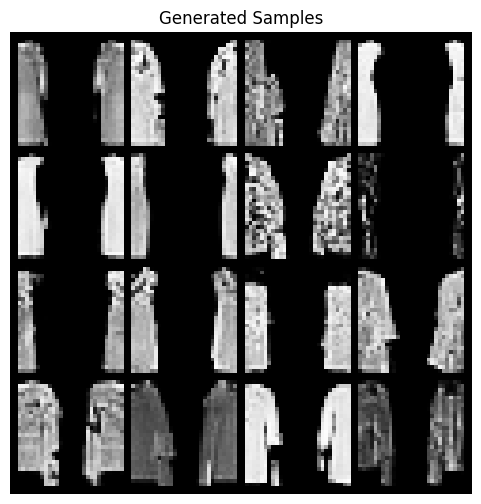

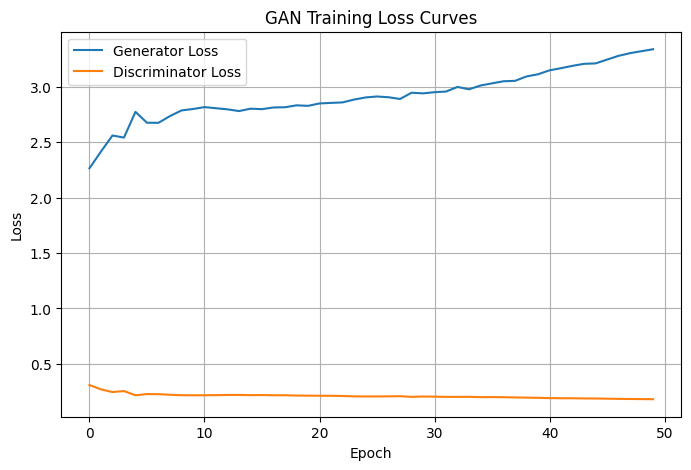

✅ Models saved successfully!

✨ Project Completed: GAN with Transformer Discriminator! ✨


In [1]:
# ==============================================
# 1. SETUP AND INSTALL DEPENDENCIES
# ==============================================
# !pip install torch torchvision tqdm matplotlib --quiet

# ==============================================
# 2. IMPORT LIBRARIES
# ==============================================
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from tqdm import tqdm
import numpy as np
import random

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set seeds for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True

# ==============================================
# 3. DATA PREPARATION
# ==============================================
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # scale to [-1, 1]
])

train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)

# ==============================================
# 4. GENERATOR (Simple CNN)
# ==============================================
class Generator(nn.Module):
    def __init__(self, noise_dim=100):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(noise_dim, 128*7*7),
            nn.BatchNorm1d(128*7*7),
            nn.ReLU(True),
            nn.Unflatten(1, (128, 7, 7)),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 1, 4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        return self.net(z)

# ==============================================
# 5. DISCRIMINATOR (Mini Transformer)
# ==============================================
class TransformerDiscriminator(nn.Module):
    def __init__(self, img_size=28, patch_size=7, embed_dim=128, num_heads=4, num_layers=2):
        super().__init__()
        assert img_size % patch_size == 0
        self.patch_dim = patch_size * patch_size
        self.num_patches = (img_size // patch_size) ** 2

        self.proj = nn.Conv2d(1, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads),
            num_layers=num_layers
        )
        self.fc = nn.Linear(embed_dim, 1)

    def forward(self, x):
        x = self.proj(x)  # (B, embed_dim, H', W')
        x = x.flatten(2).permute(2, 0, 1)  # (seq_len, batch, embed_dim)
        x = self.transformer_encoder(x)  # (seq_len, batch, embed_dim)
        x = x.mean(dim=0)  # global average pooling over sequence
        out = self.fc(x)
        return out.squeeze()

# ==============================================
# 6. INITIALIZE MODELS
# ==============================================
noise_dim = 100
generator = Generator(noise_dim=noise_dim).to(device)
discriminator = TransformerDiscriminator().to(device)

# Optimizers
g_optimizer = torch.optim.Adam(generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))

# Loss
criterion = nn.BCEWithLogitsLoss()

# ==============================================
# 7. TRAINING LOOP
# ==============================================
epochs = 50
fixed_noise = torch.randn(16, noise_dim, device=device)
g_losses, d_losses = [], []

for epoch in range(epochs):
    g_loss_epoch = 0
    d_loss_epoch = 0
    pbar = tqdm(train_loader)
    for real, _ in pbar:
        real = real.to(device)
        batch_size = real.size(0)

        ### Train Discriminator
        noise = torch.randn(batch_size, noise_dim, device=device)
        fake = generator(noise)

        real_labels = torch.ones(batch_size, device=device)
        fake_labels = torch.zeros(batch_size, device=device)

        real_pred = discriminator(real)
        fake_pred = discriminator(fake.detach())

        d_real_loss = criterion(real_pred, real_labels)
        d_fake_loss = criterion(fake_pred, fake_labels)
        d_loss = (d_real_loss + d_fake_loss) / 2

        discriminator.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        ### Train Generator
        fake_pred = discriminator(fake)
        g_loss = criterion(fake_pred, real_labels)

        generator.zero_grad()
        g_loss.backward()
        g_optimizer.step()

        g_loss_epoch += g_loss.item()
        d_loss_epoch += d_loss.item()

        pbar.set_description(f"Epoch {epoch+1} G_Loss {g_loss_epoch/len(train_loader):.4f} D_Loss {d_loss_epoch/len(train_loader):.4f}")

    g_losses.append(g_loss_epoch / len(train_loader))
    d_losses.append(d_loss_epoch / len(train_loader))

# ==============================================
# 8. VISUALIZE GENERATED SAMPLES
# ==============================================
@torch.no_grad()
def visualize_samples(generator, fixed_noise):
    generator.eval()
    fake_images = generator(fixed_noise).cpu()
    fake_images = (fake_images + 1) / 2  # [-1,1] -> [0,1]
    grid = make_grid(fake_images, nrow=4)
    plt.figure(figsize=(6,6))
    plt.imshow(grid.permute(1,2,0))
    plt.axis('off')
    plt.title('Generated Samples')
    plt.show()

visualize_samples(generator, fixed_noise)

# ==============================================
# 9. PLOT TRAINING LOSSES
# ==============================================
plt.figure(figsize=(8,5))
plt.plot(g_losses, label='Generator Loss')
plt.plot(d_losses, label='Discriminator Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GAN Training Loss Curves')
plt.grid(True)
plt.show()

# ==============================================
# 10. SAVE MODEL
# ==============================================
torch.save(generator.state_dict(), "generator_transformerGAN.pth")
torch.save(discriminator.state_dict(), "discriminator_transformerGAN.pth")
print("✅ Models saved successfully!")

# ==============================================
# 11. FINAL NOTES
# ==============================================
print("\n\u2728 Project Completed: GAN with Transformer Discriminator! \u2728")


In [2]:
# ==============================================
# Save Models - Professional Full Version
# ==============================================

import torch

# 1. Save only model weights (recommended for portability)
torch.save(generator.state_dict(), "generator_transformerGAN_weights.pth")
torch.save(discriminator.state_dict(), "discriminator_transformerGAN_weights.pth")
print("✅ Model weights saved.")

# 2. Save full training checkpoint (weights + optimizers + epoch + losses)
checkpoint = {
    'epoch': epoch if 'epoch' in locals() else epochs,
    'generator_state_dict': generator.state_dict(),
    'discriminator_state_dict': discriminator.state_dict(),
    'g_optimizer_state_dict': g_optimizer.state_dict(),
    'd_optimizer_state_dict': d_optimizer.state_dict(),
    'g_losses': g_losses,
    'd_losses': d_losses
}
torch.save(checkpoint, "transformerGAN_full_checkpoint.pth")
print("✅ Full training checkpoint saved.")

# 3. (Optional) Save full models (structure + weights)
torch.save(generator, "generator_transformerGAN_fullmodel.pth")
torch.save(discriminator, "discriminator_transformerGAN_fullmodel.pth")
print("✅ Full models (structure + weights) saved.")


✅ Model weights saved.
✅ Full training checkpoint saved.
✅ Full models (structure + weights) saved.
